## Deep Mutational Scan - Dataset

This dataset was assambled by Moritz Schäfer and the mutational information can be found in the file: 
'data/DMS/dms_curated.csv' and additional metadata in 'data/dms_metadata.csv'

In [2]:
import os
import pandas as pd
import warnings
import numpy as np
from pathlib import Path
warnings.filterwarnings("ignore")
from abag_affinity.utils.config import read_config, get_data_paths, get_resources_paths

In [4]:
config = read_config("../../config.yaml")

summary_paths, _ = get_data_paths(config, "DMS")

data_df = {}
infos = {}

for path in summary_paths:
    antibody = path.split("/")[-1].split("_")[0]
    data_df[antibody] = pd.read_csv(path)
    infos[antibody] = {}
    infos[antibody]["pdb"] = antibody + "_newcal1999.pdb"

IsADirectoryError: [Errno 21] Is a directory: '/'

In [3]:
chain_id2protein = {"d": 1, "c": 1, "b": 0}

distance_cutoff = 5

interface_hull_size = 10

In [4]:
for ab, summary_df in data_df.items():
    summary_df["scfv_mutations"] = summary_df["scfv_mutations"].fillna("")
    summary_df["scfv_mutations"] = summary_df["scfv_mutations"].apply(lambda x: ";".join([ code[0] + "D" + code[2:] for code in x.split(";") if code != ""]))
    data_df[ab] = summary_df
    
    infos[ab]["unique_mutations"] = summary_df[~summary_df["scfv_mutations"].str.contains(";")]["scfv_mutations"].tolist()
    infos[ab]["mutation_locations"] = [(mut[1], mut[2:-1]) for mut in infos[ab]["unique_mutations"] if mut != ""]

## Interface analysis

Get residues that are present in the interface (AB residue <10A distance to AG residue)

In [5]:
from abag_affinity.utils.pdb_processing import get_residue_infos, get_distances, get_residue_edge_encodings, get_atom_encodings, get_atom_edge_encodings
from abag_affinity.utils.pdb_reader import read_file

In [6]:
for ab, info in infos.items():
    structure_file = info["pdb"]
    structure, header = read_file("struct", os.path.join(resourde_pdb_path, structure_file))
    structure_info, residue_infos, residue_atom_coordinates = get_residue_infos(structure, header, chain_id2protein)
    atom_encodings, atom_names = get_atom_encodings(residue_infos, structure_info, chain_id2protein)
    distances, closest_residue_indices = get_distances(residue_infos, residue_distance=False, ca_distance=False)
    A = get_atom_edge_encodings(distances, atom_encodings, distance_cutoff=5)
    infos[ab]["residue_infos"] = residue_infos
    infos[ab]["atom_encodings"] = atom_encodings
    infos[ab]["atom_names"] = atom_names
    infos[ab]["distances"] = distances
    infos[ab]["A"] = A
    infos[ab]["structure"] = structure

In [7]:
for ab, info in infos.items():

    residue_distances, _ = get_distances(info["residue_infos"], residue_distance=True, ca_distance=False)

    contact_map = residue_distances < distance_cutoff
    interface_distances = np.zeros_like(residue_distances)
    interface_distances[contact_map] = residue_distances[contact_map]
    infos[ab]["interface_distances"] = interface_distances

#### Visualize Interface contacts

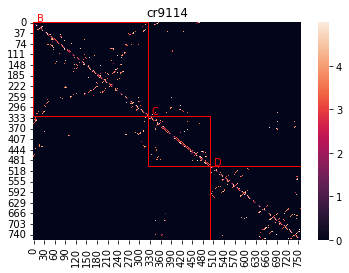

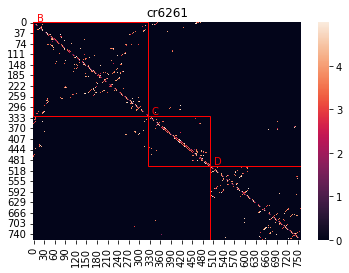

In [8]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns

for i, (ab, info) in enumerate(infos.items()):
    structure = info["structure"]

    chain_lengths = []
    for chain in structure.get_chains():
        residue_list = list(chain.get_residues())
        chain_name = chain.id
        chain_lengths.append((len(residue_list), chain_name))
    plt.figure(i)
    ax = sns.heatmap(info["interface_distances"])
    ax.set_title(ab)
    total_length = 0
    for length, chain_name in chain_lengths:
        plt.text(total_length + 10, total_length - 5, chain_name, color="r")
        rect = Rectangle((total_length, total_length), length, length, linewidth=1, edgecolor='r', facecolor='none')
        total_length += length
        ax.add_patch(rect)

plt.show()

## Filter mutations in interface

In [9]:
def filter_interface(A, unique_mutations):
    interface = A[0, :, :] - A[2, :, :]
    interface_atoms = np.where(interface > 0.001)[0]

    interface_atoms = np.unique(interface_atoms)

    interface_hull = np.where(A[3, interface_atoms, :] < interface_hull_size)
    interface_hull_atoms = np.unique(interface_hull[1])
    
    
    interface_residues = set()

    for atom in interface_hull_atoms:
        res_index = int(atom_encodings[atom][-1])
        node_info = residue_infos[res_index]
        residue_id = node_info["residue_id"]
        atom_name = atom_names[atom]
        chain_id = node_info["chain_id"]

        interface_residues.add((chain_id, residue_id))
        
    pdb_id = structure_file.split(".")[0]

    select = f"select res_hull, "

    for chain_id, res_id in interface_residues:

        select += f"({pdb_id} and chain {chain_id} and resi {res_id}) OR "
        
    mutations_in_interface = []

    for mutation in unique_mutations:
        if mutation == "":
            mutations_in_interface.append(mutation)
            continue
        chain = mutation[1]
        chain_idx = int(mutation[2:-1])

        if (chain, chain_idx) in interface_residues:
            mutations_in_interface.append(mutation)
            
    mutations_not_in_interface = set(unique_mutations) - set(mutations_in_interface)
    
    return mutations_in_interface, mutations_not_in_interface


In [10]:
for ab, info in infos.items():
    infos[ab]["mutations_in_interface"], infos[ab]["mutations_not_in_interface"] = filter_interface(info["A"], info["unique_mutations"])
    print(f"{ab} antibody: {len(infos[ab]['mutations_in_interface'])} of {len(infos[ab]['unique_mutations'])} mutations are in interface hull")

cr9114 antibody: 14 of 17 mutations are in interface hull
cr6261 antibody: 11 of 12 mutations are in interface hull


In [11]:
def only_interface_mutations(row, ab):
    mutations = row["scfv_mutations"].split(";")
    for mutation in mutations:
        if mutation not in infos[ab]["mutations_in_interface"]:
            return False
    
    return True


relevant_cols = {
    "cr9114": ["h1_mean", "h3_mean", "fluB_mean"],
    "cr6261": ["h1_mean", "h9_mean"]
}

col2pdb = {
    "cr9114":{
        "h1": "newcal1999",
        "h3": "wiscons2005",
        "fluB": "ohio2005",
    },
    "cr6261":{
        "h1": "newcal1999",
        "h9": "hongkong1999"
    }
}

mutation_dfs = []

for ab, summary_df in data_df.items():
    summary_df["mutations_in_interface"] = summary_df.apply(lambda row: only_interface_mutations(row, ab), axis=1)
    cleaned_df = summary_df[summary_df["mutations_in_interface"]].copy()
    cleaned_df = cleaned_df[relevant_cols[ab] + ["scfv_mutations"]]
    cleaned_df["antibody_id"] = ab
    cleaned_df["mutation_code"] = cleaned_df["scfv_mutations"]
    for col, pdb_name in col2pdb[ab].items():
        col += "_mean"
        mutation_df = cleaned_df[["antibody_id", col, "mutation_code"]].copy()
        mutation_df["pdb_file"] = pdb_name
        mutation_df.rename(columns = {col: "-log(Kd)"}, inplace = True)
        mutation_df = mutation_df[~mutation_df["-log(Kd)"].isna()]
        mutation_df = mutation_df[["antibody_id", "pdb_file", "mutation_code", "-log(Kd)"]]
        mutation_df["chain_infos"] = str(chain_id2protein)
        mutation_dfs.append(mutation_df)
    data_df[ab] = cleaned_df

### Convert to standard format

In [12]:
def get_filename(row):
    if row["mutation_code"] == "":
        return row["pdb"] + ".pdb"
    else:
        return row["pdb"] + "_" + row["mutation_code"] + ".pdb"

In [13]:
final_df = pd.concat(mutation_dfs).reset_index(drop=True)

final_df["pdb"] = final_df.apply(lambda row: row["antibody_id"] + "_" + row["pdb_file"], axis=1)

final_df["data_location"] = "DATA"
final_df.loc[final_df["mutation_code"] == "", "data_location"] = "RESOURCES"

final_df["filename"] = final_df.apply(get_filename, axis=1)

converted_df = final_df[["pdb", "data_location", "filename", "-log(Kd)", "chain_infos", "mutation_code"]]

In [14]:
def get_index(row):
    if row["mutation_code"] == "":
        return row["pdb"]
    else:
        return row["pdb"] + "-" + row["mutation_code"].lower()

converted_df["index"] = converted_df.apply(get_index, axis=1)
converted_df = converted_df.set_index("index")
converted_df.index.name = ""

In [16]:
data_path, [pdb_path] = get_data_paths(config, "DMS_phillips21")
Path(pdb_path).mkdir(exist_ok=True, parents=True)

converted_df.to_csv(data_path)

### Plot Distribution of -log(Kd) values

In [17]:
all_complexes = final_df.apply(lambda row: row["antibody_id"] + "_" + row["pdb_file"], axis=1).tolist()
all_mutations = final_df.apply(lambda row: row["mutation_code"], axis=1)
unique_complexes = all_mutations.unique().tolist()
all_mutations = all_mutations.tolist()

array([[<AxesSubplot:title={'center':'cr6261_hongkong1999'}>,
        <AxesSubplot:title={'center':'cr6261_newcal1999'}>],
       [<AxesSubplot:title={'center':'cr9114_newcal1999'}>,
        <AxesSubplot:title={'center':'cr9114_ohio2005'}>],
       [<AxesSubplot:title={'center':'cr9114_wiscons2005'}>,
        <AxesSubplot:>]], dtype=object)

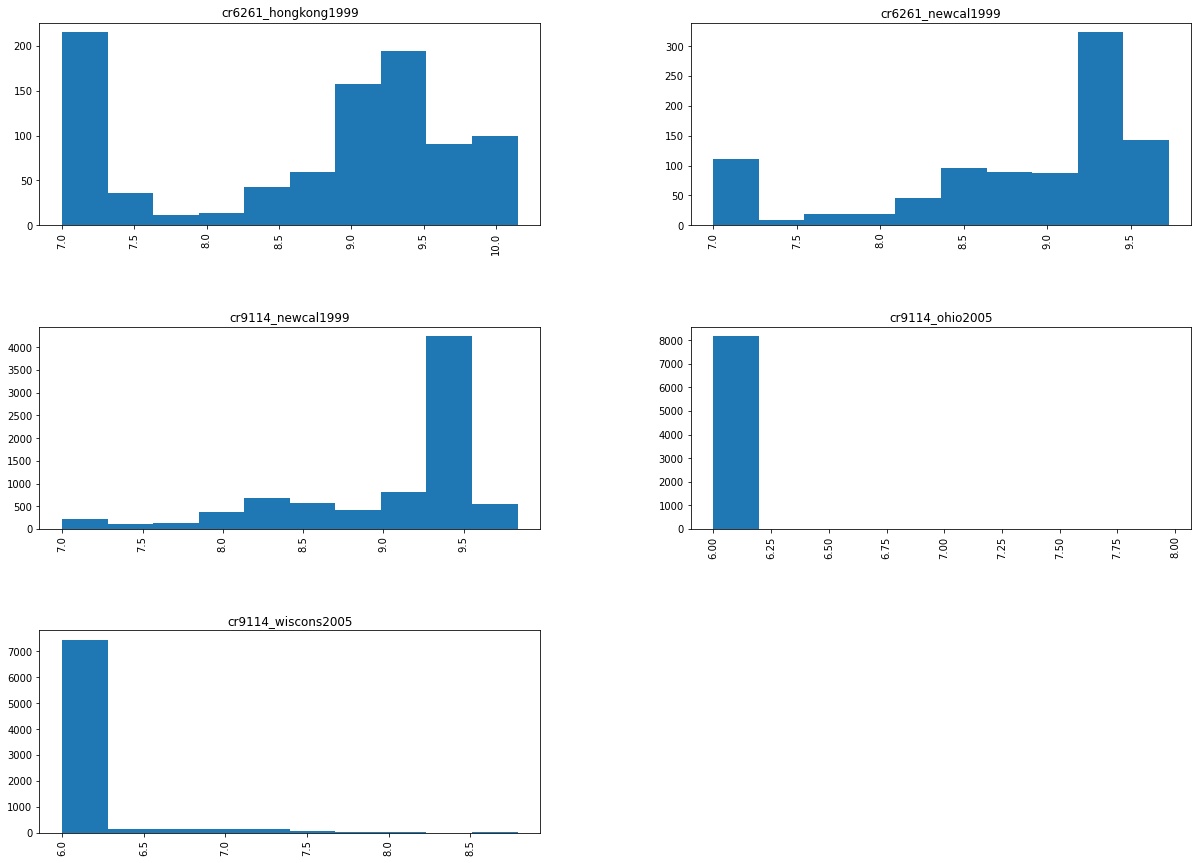

In [18]:
groups = final_df.apply(lambda row: row["antibody_id"] + "_" + row["pdb_file"], axis=1)

final_df["-log(Kd)"].hist(bins=10,by=groups, figsize=(20,15))

### Test if mutations are correct

In [19]:
import pyrosetta
from pyrosetta.toolbox.mutants import mutate_residue
from pyrosetta.rosetta.core.pose import Pose, add_comment, dump_comment_pdb
from typing import List, Dict

In [20]:
three2one_code = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


def convert_mutations(mutation_code: str):
    if len(mutation_code) == 0:
        return []

    mutation_codes = mutation_code.split(";")

    decoded_mutations = []
    for code in mutation_codes:
        mutation_info = {
            "original_amino_acid": code[0],
            "chain": code[1],
            "index": int(code[2:-1]),
            "new_amino_acid": code[-1],
            "code": mutation_code
        }
        decoded_mutations.append(mutation_info)

    return decoded_mutations


def check_mutation(pose: Pose, mutation):
    # check if mutation is correct
    original_residue = pose.pdb_rsd((mutation["chain"], mutation["index"])).name().split(":")[0]
    return three2one_code[original_residue.upper()] == mutation["original_amino_acid"]

def load_pose(pdb_path: str) -> pyrosetta.Pose:
    try:
        pose = pyrosetta.pose_from_pdb(pdb_path)
    except RuntimeError:
        pose = load_pose_without_header(pdb_path)
    testPose = pyrosetta.Pose()
    testPose.assign(pose)
    return testPose

def load_pose_without_header(pdb_path: str):
    with open(pdb_path) as f:
        lines = f.readlines()

    i = 0
    while True:
        if lines[i][:4] != "ATOM":
            i += 1
        else:
            break

    new_path = pdb_path.split(".")[0] + "_tmp.pdb"

    with open(new_path, "w") as f:
        f.writelines(lines[i:])

    pose = pyrosetta.pose_from_pdb(new_path)

    os.remove(new_path)

    return pose

In [21]:
pyrosetta.init(extra_options="-mute all")


wrong_mutations = []
corrected_mutations = []

print("Check Mutations...\n\n")
for ab, info in infos.items():
    pose = load_pose(os.path.join(resourde_pdb_path, info["pdb"]))

    for mutation in info["unique_mutations"]:
        if mutation == "":
            continue
        converted_mut = convert_mutations(mutation)[0]
        if not check_mutation(pose, converted_mut):
            wrong_mutations.append(converted_mut)
            original_residue = pose.pdb_rsd((converted_mut["chain"], converted_mut["index"])).name()
            corrected_mutations.append(original_residue)
        
    print(f"Wrong mutations for {ab}: ", len(wrong_mutations))

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
Check Mutations...


Wrong mutations for cr9114:  0
Wrong mutations for cr6261:  0
